# (06) MNIST — Gaussian — 0

**Motivation**: First fit a standard Gaussian VAE to MNIST. Device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.mnist import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
n_latents = 2

batch_size = 500
epochs = 300

gvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    mode='G',
    device_idx=0,
    n_latents=n_latents,
    max_grad_norm=200,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| GaussianVAE |  7.8 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|     dec     |  1.2 Mil   |
+-------------+------------+

## Train / Validate

### trn

In [4]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl = iteration(
        ep, gvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 88.0,  loss = (kl: 6.2, recon: 25.0  ——  tot: 31.28)  : 100%|████████████████████████████| 300/300 [51:10<00:00, 10.24s/it]

CPU times: user 1h 20min 22s, sys: 2min 2s, total: 1h 22min 25s
Wall time: 51min 10s


### vld

In [5]:
emb, labels, loss_vld = validate(gvae, vld, device)
loss_vld

{'kl': 6.235265283203125,
 'recon': 25.526587792968748,
 'tot': 31.76185322265625}

{'kl': 6.347746307709638,
 'recon': 25.453759827333336,
 'tot': 31.80150604248047}

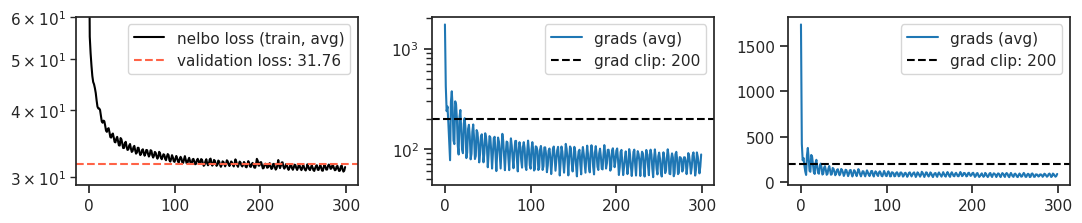

In [6]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
axes[0].set_ylim(top=60)
plt.show()

### make some plots

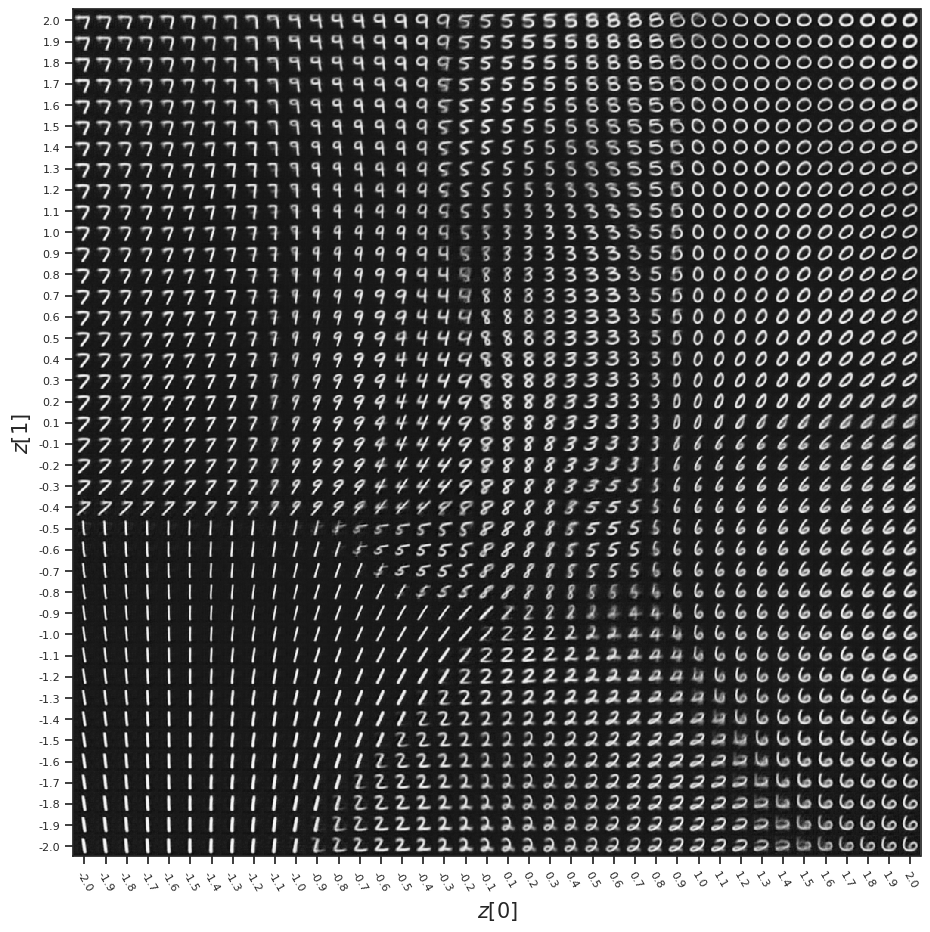

In [7]:
_ = plot_latent_space(gvae.dec, device, 2.0, 40)

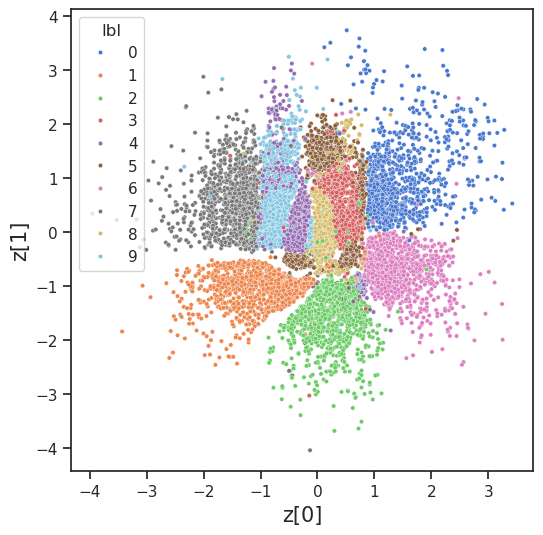

In [8]:
_ = plot_latent_scatter(emb, labels, (0, 1), (6, 6), 10)

In [9]:
n_samples = 50

with torch.inference_mode():
    samples = torch.empty((n_samples, n_latents), device=device)
    samples = samples.normal_(0, 1)
    x_samples = gvae.dec(samples)

x_samples.shape

torch.Size([50, 1, 28, 28])

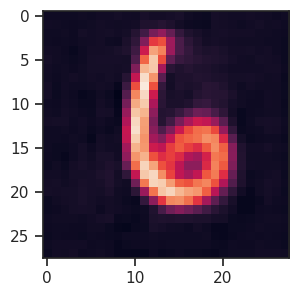

In [10]:
plt.imshow(to_np(x_samples[11, 0]))

In [11]:
from torchvision.utils import make_grid

In [12]:
grid_images = make_grid(x_samples, nrow=10, normalize=True, value_range=(0, 1))
grid_images.shape

torch.Size([3, 152, 302])

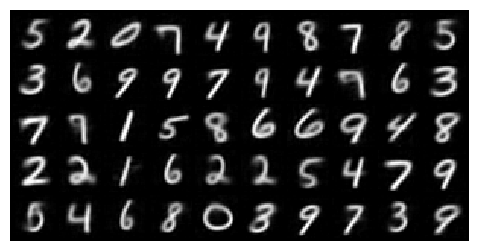

In [13]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (10, 3))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

In [14]:
x, _ = next(iter(vld))
x = x.to(device)
with torch.inference_mode():
    out = gvae(x)
out['x_recon'].shape

torch.Size([500, 1, 28, 28])

In [15]:
num = 32

grid_images = make_grid(
    torch.cat([x[:num], out['x_recon'][:num]]),
    nrow=num,
    normalize=True,
    value_range=(0, 1),
)
grid_images.shape

torch.Size([3, 62, 962])

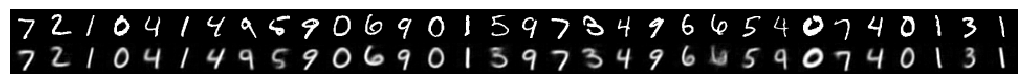

In [16]:
x2p = to_np(grid_images)
x2p = np.transpose(x2p, (1, 2, 0))

fig, ax = create_figure(1, 1, (13, 5))
ax.imshow(x2p)
remove_ticks(ax)
plt.show()

In [17]:
path = '/home/hadi/Documents/vae'

torch.save(
    obj={'epoch': epochs,
         'batch_size': batch_size,
         'model_state_dict': gvae.state_dict(),
         'optimizer_state_dict': optim.state_dict(),
         'loss': loss_vld},
    f=pjoin(path, '0.pt'),
)